# Combine *Cluster Failure* False Positive Maps
1. Flirt AFNI and SPM false cluster maps into MNI space (FSL maps are already there).
2. Mask maps with FSL's MNI152 2mm brain mask.
3. Weight values by prevalence of the package in the literature.
    - I just searched *fmri afni*, *fmri fsl*, and *fmri spm* in Google Scholar (on 170311) to get the estimated prevalence of each package.
    - Instead of looking into the individual tools within each package, I just divided the package number by the number of tools within the package (1 or 2).
4. Combine weighted maps (just add them together).
5. Normalize combined map so that each voxel's value is a probability.

In [1]:
%matplotlib inline
from __future__ import division
import gzip
import shutil
import numpy as np
import nibabel as nib
from glob import glob
from os import remove
import seaborn as sns
import matplotlib.pyplot as plt
from nipype.interfaces import fsl
from os.path import join, basename, splitext

/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
in_dir = '/scratch/tsalo006/ParametricMultisubjectfMRI/Results/'
out_dir = join(in_dir, 'mni/')

brain_mask = '/home/applications/fsl/5.0.8/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
epi_template = '/home/data/nbc/tools/spm8/templates/EPI.nii'

# Relative frequency of each tool in the literature.
tools = ['AFNIMEMA', 'AFNIOLS', 'FSLFLAME', 'FSLOLS', 'SPM']
freqs = [11000./2,   11000./2,  15700./2,   15700./2, 46600.]
freqs = freqs / np.sum(freqs)

In [3]:
mask = nib.load(brain_mask)
mask = mask.get_data().astype(float)

In [4]:
fs = sorted(glob(join(in_dir, 'falseclusters_*.nii')))
all_data = [[] for _ in range(len(fs))]

for i, f in enumerate(fs):
    fname = basename(splitext(f)[0])
    
    gz_f = join(in_dir, 'gzipped_{0}.nii.gz'.format(fname))
    flirted_f = join(out_dir, '{0}.nii.gz'.format(fname))
    #masked_f = join(out_dir, 'masked_{0}.nii.gz'.format(fname))
    
    # Gzip original files.
    with open(f, 'rb') as fi, gzip.open(gz_f, 'wb') as fo:
        shutil.copyfileobj(fi, fo)
    
    if 'FSL' not in fname:
        # FLIRT AFNI and SPM maps to MNI.
        flt = fsl.FLIRT(bins=640, cost_func='mutualinfo')
        flt.inputs.in_file = gz_f
        flt.inputs.reference = epi_template
        flt.inputs.out_file = flirted_f
        flt.inputs.output_type = 'NIFTI_GZ'
        flt.run()
    else:
        # FSL maps already in MNI space.
        shutil.copyfile(gz_f, flirted_f)

    # Mask each map with the MNI152 brain mask.
    dat = nib.load(flirted_f)
    data = dat.get_data()
    if i == 0:
        updated_mask = (data>0).astype(float)
        updated_mask *= mask
    else:
        updated_mask *= (data>0).astype(float)
    data *= mask
    #img = nib.Nifti1Image(data, dat.affine)
    #img.to_filename(masked_f)
    
    # Remove gzipped files.
    remove(gz_f)
    
    # Weight each map by tool's relative popularity.
    # Combine maps.
    for j, tool in enumerate(tools):
        if tool in fname:
            if j == 0:
                combined = data * freqs[j]
            else:
                combined += data * freqs[j]

# Write out unnormalized map.
combined *= updated_mask
img = nib.Nifti1Image(combined, dat.affine)
img.to_filename(join(out_dir, 'falseclusters_average.nii.gz'))

# Write out normalized map.
normed = combined / np.sum(combined)
img = nib.Nifti1Image(normed, dat.affine)
img.to_filename(join(out_dir, 'falseclusters_average_normed.nii.gz'))

In [8]:
# Mask map with the MNI152 brain mask.
inv = np.max(combined) - combined
inv *= updated_mask
data *= mask

# Write out map.
img = nib.Nifti1Image(inv, dat.affine)
img.to_filename(join(out_dir, 'falseclusters_average_inv.nii.gz'))

In [9]:
n_fp_vec = combined[updated_mask>0]
n_fp_vec_inv = inv[updated_mask>0]
print('Bottom five percent inverse value: {0}'.format(np.percentile(n_fp_vec_inv, 95)))
print('Top five percent value: {0}'.format(np.percentile(n_fp_vec, 95)))

Bottom five percent inverse value: 66.116683903
Top five percent value: 42.2155765705


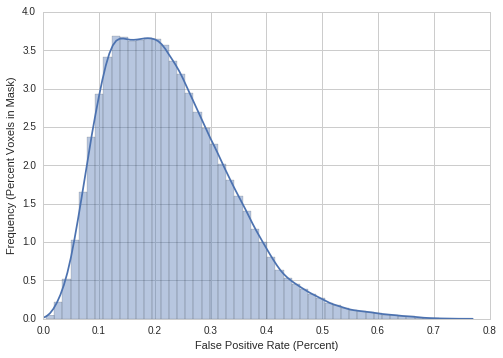

In [10]:
# Plot distribution of false positives.
sns.set_style('whitegrid')
arr = 100. * (n_fp_vec / 10000.) # Convert to FPR in percent
fig, ax = plt.subplots()
sns.distplot(arr, ax=ax)
ax.set_ylabel('Frequency (Percent Voxels in Mask)')
ax.set_xlabel('False Positive Rate (Percent)')
ax.set_xlim((0.0))
fig.show()